## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
plt.rcParams["figure.figsize"] = (12,8)

# Import Data

In [2]:
data=pd.read_csv('train_IxoE5JN.csv',parse_dates=True)

In [3]:
data.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   row_id    94992 non-null  int64  
 1   datetime  94992 non-null  object 
 2   energy    93092 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


In [257]:
#Extarct year and month from datetime 

In [5]:
data['datetime']=pd.to_datetime(data['datetime'])
data['year']=data['datetime'].dt.year
data['month']=data['datetime'].dt.month

In [6]:
data.isnull().sum()

row_id         0
datetime       0
energy      1900
year           0
month          0
dtype: int64

C:\Users\vikas.reddy\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='energy', ylabel='Density'>

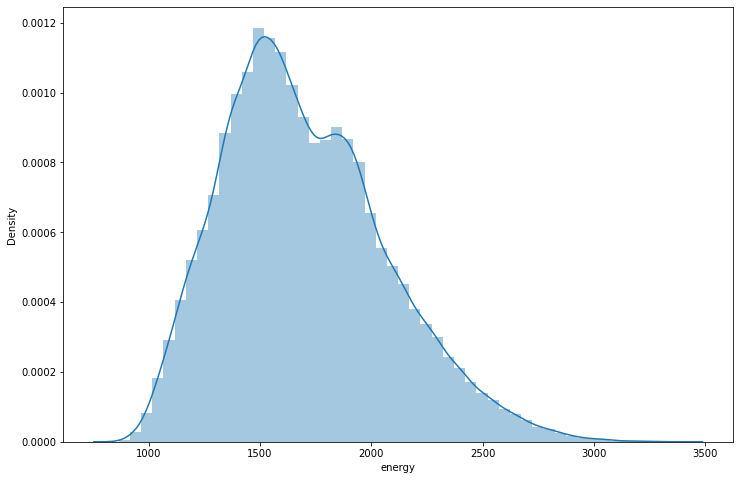

In [7]:
sns.distplot(data.energy)

In [8]:
data.energy.mean()

1702.9950139488076

In [9]:
data.energy.median()

1654.4658

In [10]:
data.set_index('datetime',inplace=True)

<AxesSubplot:xlabel='datetime'>

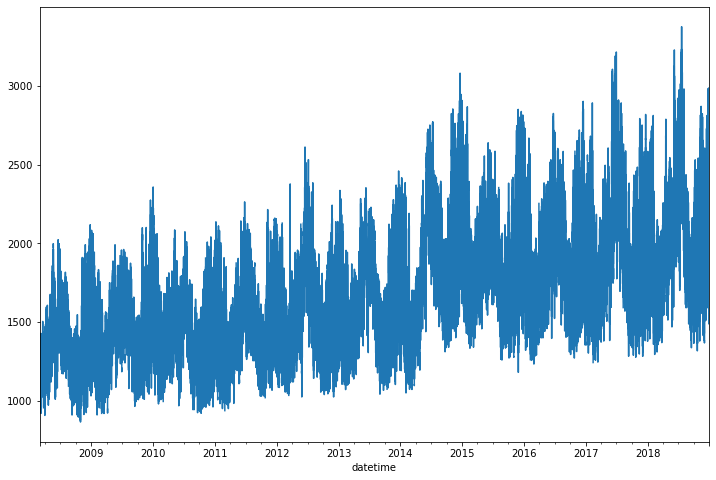

In [11]:
data.energy.plot()

In [258]:
# Fill the null values of energy by bfill method

In [12]:
data.fillna(method='bfill',inplace=True)

<AxesSubplot:xlabel='month', ylabel='energy'>

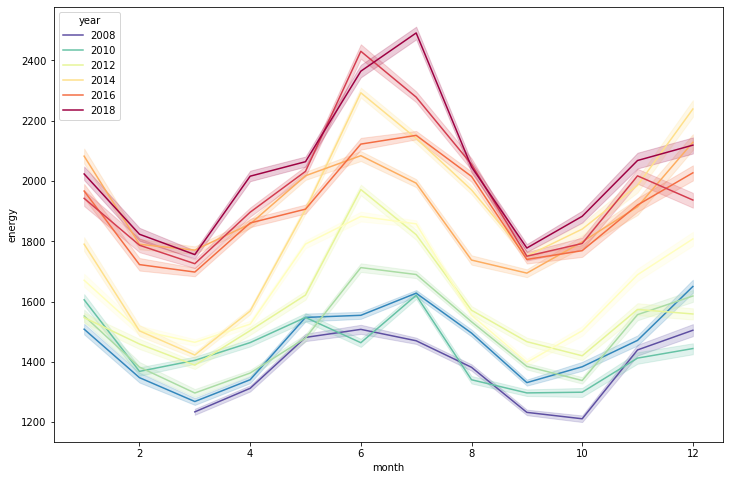

In [13]:
sns.lineplot(x='month',y='energy',hue='year',data=data,palette='Spectral_r')

# We can see that data has significant seasonal variation

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

##  By Additive Decomposition

In [16]:
result=seasonal_decompose(data['energy'],model='additive',extrapolate_trend='freq')

Text(0.5, 0.98, 'nAdditive Decompose')

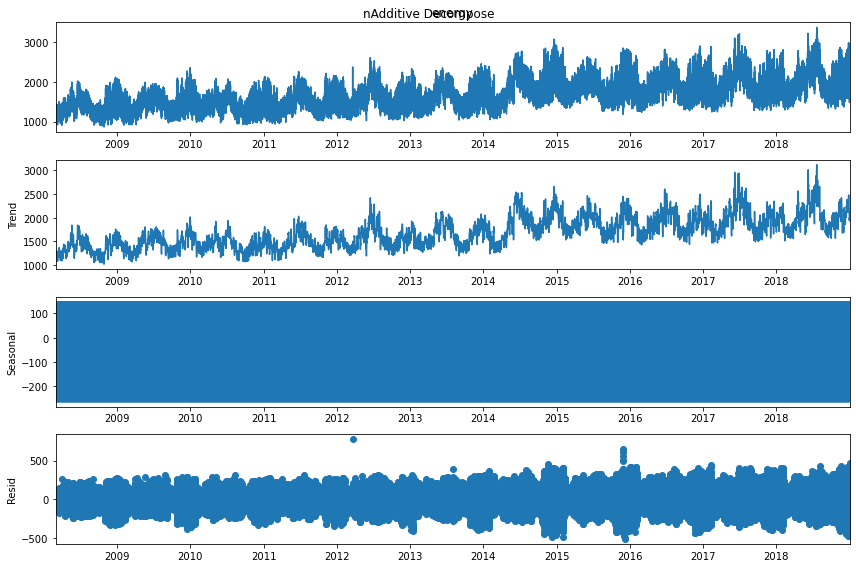

In [17]:
result.plot().suptitle('nAdditive Decompose', fontsize=12)

C:\Users\vikas.reddy\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='resid', ylabel='Density'>

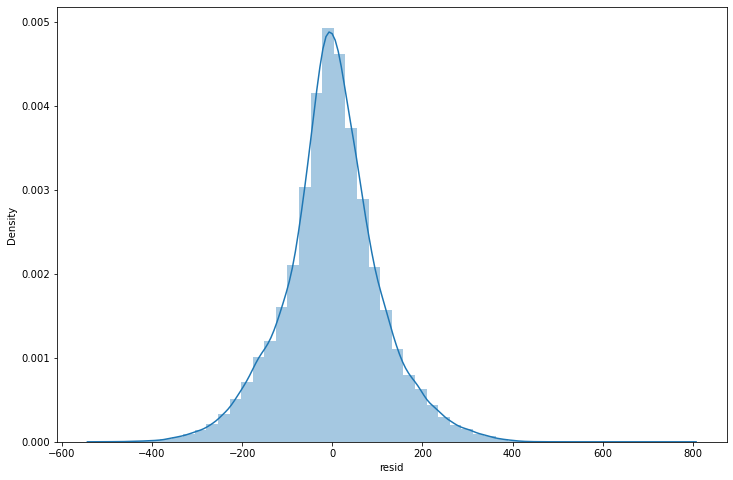

In [18]:
sns.distplot(result.resid) # Checking the residual

## BY  Multiplicative Decomposition

Text(0.5, 0.98, 'nMultiplicative')

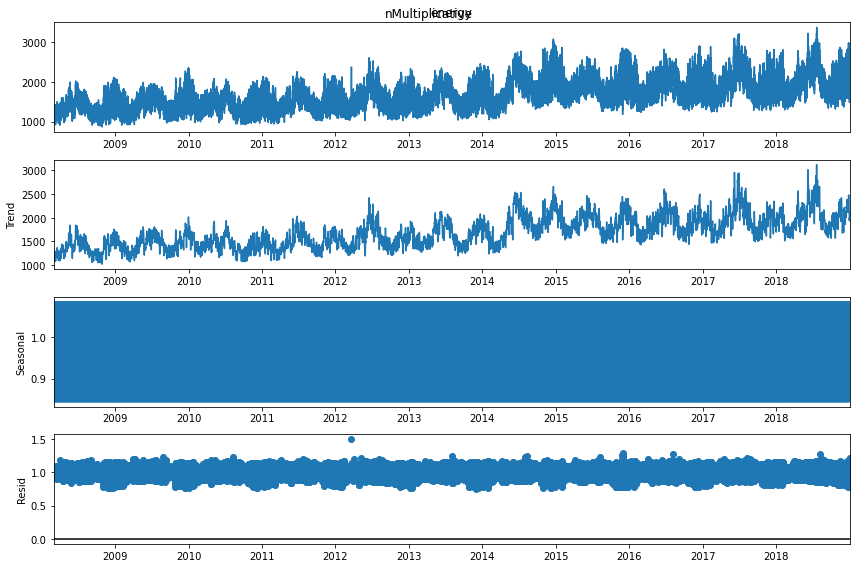

In [20]:
result_m=seasonal_decompose(data['energy'],model='multiplicative',extrapolate_trend='freq')
result_m.plot().suptitle('nMultiplicative', fontsize=12)


C:\Users\vikas.reddy\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='resid', ylabel='Density'>

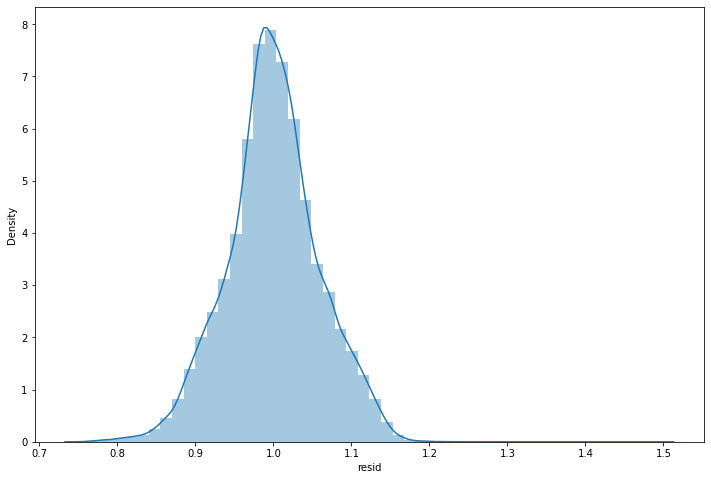

In [21]:
sns.distplot(result_m.resid)

1. The residuals from both additive and multiplicative decomposition follows normal distribution
2. The residual still has some information after decomposition

# Check for Stationarity

In [22]:
from statsmodels.tsa.stattools import adfuller
adfuller_result = adfuller(data.energy, autolag='AIC')
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')
for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -9.225224835583811
p-value: 1.7364588801847518e-15
Critial Values:
   1%, -3.4304188917117377
Critial Values:
   5%, -2.8615704490393217
Critial Values:
   10%, -2.5667862069612752


## p value is less than 0.05 so, the data is stationary  and good for modelling

In [23]:
# Data is stationary

# Model RNN

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [25]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

In [26]:
from keras.preprocessing.sequence import TimeseriesGenerator

## Importing libraries and creating LSTM layers 

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [28]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(12,1)))
model.add(Dense(100))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 51,001
Trainable params: 51,001
Non-trainable params: 0
_________________________________________________________________


In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
test=pd.read_csv('test_WudNWDM.csv',parse_dates=True)

In [32]:
test['datetime']=pd.to_datetime(test['datetime'])

In [33]:
test.set_index('datetime',inplace=True)

In [34]:
data.drop(['row_id','year','month'],axis=1,inplace=True)

In [35]:
scaler.fit(data)
scaled_train = scaler.transform(data)
scaled_test = scaler.transform(test)

C:\Users\vikas.reddy\Anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- row_id
Feature names seen at fit time, yet now missing:
- energy

  warnings.warn(message, FutureWarning)


In [36]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [37]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.1569359  0.09136838 0.07570098]
Predict this y: 
 [[0.06712626]]


In [38]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [39]:
# fit model
model.fit(generator,epochs=30,callbacks=[callback],batch_size=128)

Epoch 1/30
94980/94980 [==============================] - 454s 5ms/step - loss: 3.7203e-04
Epoch 2/30
94980/94980 [==============================] - 456s 5ms/step - loss: 2.4687e-04
Epoch 3/30
94980/94980 [==============================] - 1000s 11ms/step - loss: 2.2441e-04
Epoch 4/30
94980/94980 [==============================] - 1028s 11ms/step - loss: 2.1475e-04
Epoch 5/30
94980/94980 [==============================] - 1047s 11ms/step - loss: 2.0653e-04
Epoch 6/30
94980/94980 [==============================] - 1055s 11ms/step - loss: 1.9837e-04
Epoch 7/30
94980/94980 [==============================] - 1067s 11ms/step - loss: 1.9401e-04
Epoch 8/30
94980/94980 [==============================] - 1069s 11ms/step - loss: 1.9016e-04
Epoch 9/30
94980/94980 [==============================] - 1080s 11ms/step - loss: 1.8505e-04
Epoch 10/30
94980/94980 [==============================] - 1072s 11ms/step - loss: 1.8132e-04
Epoch 11/30
94980/94980 [==============================] - 1082s 11ms/ste

In [40]:
last_train_batch = scaled_train[-12:]

In [41]:
# Checking predictions
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [42]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 329ms/step


array([[0.46434593]], dtype=float32)

In [43]:
scaled_test[0]

array([37.5303822])

## Predictions

In [44]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) 

1/1 [==============================] - 0s 20ms/step


In [45]:
true_predictions = scaler.inverse_transform(test_predictions)

In [46]:
len(true_predictions)

26304

In [47]:
len(test)

26304

In [48]:
test['energy']=true_predictions

# Creating Output Csv

In [49]:
test.to_csv('job_hack_sub_3.csv',index=False)